sources:

https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images?resource=download

https://medium.com/@vineethrajesh2/loading-in-your-own-image-datasets-in-pytorch-9e4064171074

https://www.kaggle.com/code/agnesa/efficientnet-detect-ai-vs-human-generated-images

In [ ]:
#assorted
import numpy as np
import os
import psutil
import matplotlib.pyplot as plt
import seaborn as sns #literally only used for the lineplot? surely plt can do that too
from tqdm import tqdm
import random
import typing

#torch model
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F #difference between that and torch.relu or torch.nn.Module.maxpool2d etc? Not much really just how to use it

from typing import NamedTuple

#metrics
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#torchcam
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from torch.optim.lr_scheduler import CosineAnnealingLR

In [14]:
#transforms
train_transforms = transforms.Compose([
    transforms.ToTensor(), #can also do some resizing and normalizing
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #mean and std for normalization
	transforms.RandomHorizontalFlip(), #randomly flip the image horizontally
])

test_transforms = transforms.Compose([
    transforms.ToTensor(), #can also do some resizing and normalizing
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [15]:
#get num_workers, device, batch size
def count_workers() -> int: 
	try:
		vCPUs = os.cpu_count() 
		if vCPUs is None: 
			vCPUs = psutil.cpu_count(logical = False)
		return vCPUs
	except Exception as e:
		return 1
	
def get_device() -> torch.device:
	if torch.backends.mps.is_available():
		return torch.device("mps")
	else:
		return torch.device("cpu")

workers=count_workers()
device = get_device()
batch_size = 128
epochs = 60
lr=0.001

print(f"cores: {workers}, device: {device}, batch_size: {batch_size}, epochs: {epochs}, learning rate: {lr}")

cores: 8, device: mps, batch_size: 128, epochs: 60, learning rate: 0.001


In [16]:
#load actual data
train_data = ImageFolder("data_test/train", transform=train_transforms)
test_data = ImageFolder("data_test/test", transform=test_transforms)

#dataloaders
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    #collate_fn=collate, #collate_fn is used to combine multiple samples into a batch
    num_workers=workers, #number of workers to LOAD data in parallel (not to crunch numbers. for some reason it's different)
    persistent_workers=True
	)
test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    persistent_workers=True
    )

In [17]:
os.path.exists("data_test")

True

In [18]:
#check how many images in the dataset
print(len(train_data)) #100k
print(len(test_data)) #20k

#check the classes
print(type(train_data)) #torchvision.datasets.folder.ImageFolder
# print(train_data.classes) #0 is fake and 1 is real
# print(test_data.classes)

#check the shape of the images
print(train_data[0][0].shape) #3 channels, 32 x 32 px
print(train_data[0]) #0 or 1, fake or real

100000
20000
<class 'torchvision.datasets.folder.ImageFolder'>
torch.Size([3, 32, 32])
(tensor([[[0.4471, 0.4667, 0.4588,  ..., 0.4863, 0.4157, 0.2118],
         [0.4980, 0.4980, 0.4863,  ..., 0.4039, 0.3176, 0.1804],
         [0.5216, 0.5020, 0.4902,  ..., 0.2824, 0.1961, 0.1569],
         ...,
         [0.1412, 0.1451, 0.1529,  ..., 0.3490, 0.3451, 0.3490],
         [0.1412, 0.1490, 0.1569,  ..., 0.3647, 0.3451, 0.3412],
         [0.1373, 0.1451, 0.1647,  ..., 0.3922, 0.3882, 0.3843]],

        [[0.4392, 0.4588, 0.4588,  ..., 0.4706, 0.4000, 0.1961],
         [0.4902, 0.4902, 0.4863,  ..., 0.3882, 0.3020, 0.1647],
         [0.5137, 0.4941, 0.4902,  ..., 0.2667, 0.1804, 0.1451],
         ...,
         [0.1059, 0.1098, 0.1176,  ..., 0.3216, 0.3176, 0.3216],
         [0.1137, 0.1216, 0.1294,  ..., 0.3294, 0.3176, 0.3137],
         [0.1176, 0.1255, 0.1373,  ..., 0.3569, 0.3569, 0.3529]],

        [[0.4431, 0.4627, 0.4510,  ..., 0.4667, 0.3961, 0.1922],
         [0.4941, 0.4941, 0.4784,  

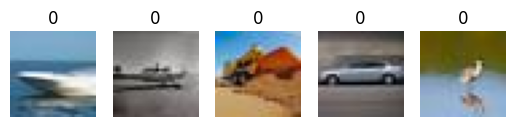

In [19]:
#print n images in train_data starting from starting_index
n_images = 5
starting_index=3908
for i in range(n_images):
	plt.subplot(1, 5, i + 1) #subplot with 1 row and 5 columns
	plt.imshow(train_data[starting_index + i][0].permute(1, 2, 0)) #permute to get channels last
	plt.title(train_data[starting_index + i][1]) #show the label of the image, 0 is the index of the image
	plt.axis('off') #remove axis
plt.show()

In [20]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
#initialize model
model = CNN()
model

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

In [23]:
#training loop
def train_cnn(model: nn.Module, train_loader, test_loader, epochs: int = 1000):
	print(f"Training on {device}")
	# Convert everything to tensors first
	loss_ls = []
	f1_ls = []
	accuracy_score_ls = []
	model = model.to(device)

	for epoch in tqdm(range(epochs)):
		model.train()
		for features, target in train_loader:
			features, target = features.to(device), target.to(device)	
			optimizer.zero_grad()
			outputs = model(features)
			loss = criterion(outputs, target)
			loss.backward()
			optimizer.step()

		model.eval()
		#with torch.no_grad():
		total_loss = 0
		combined = []
		for features, target in test_loader:
			features, target = features.to(device), target.to(device)
			output = model(features)
			loss = criterion(output, target)
			total_loss += loss.item()
			label_out = torch.argmax(output, dim=1) #argmax returns the index of the maximum value in the tensor
			combined.append({"pred": label_out, "true": target})
		
		combined_true = np.concatenate([c["true"].cpu().numpy() for c in combined])
		combined_pred = np.concatenate([c["pred"].cpu().numpy() for c in combined])

		f1 = f1_score(combined_true, combined_pred)
		accuracy = accuracy_score(combined_true, combined_pred)
		loss_ls.append(total_loss / len(test_loader))
		f1_ls.append(f1)
		accuracy_score_ls.append(accuracy)
		print(f"Epoch {epoch + 1} \nLoss: {total_loss / len(test_loader)} \nF1 Score: {np.mean(f1)} \nAccuracy: {accuracy}") #is something wrong with my f1 score here? take fake/fake as true positive or real/real as true positive?
	return loss_ls, f1_ls, accuracy_score_ls

In [24]:
loss_ls, f1_ls, accuracy_score_ls = train_cnn(model, train_loader, test_loader, epochs)

Training on mps


  2%|▏         | 1/60 [01:00<59:09, 60.17s/it]

Epoch 1 
Loss: 0.46156421654922947 
F1 Score: 0.8002126811112588 
Accuracy: 0.77455


  3%|▎         | 2/60 [01:21<36:11, 37.44s/it]

Epoch 2 
Loss: 0.3527190724186077 
F1 Score: 0.8498242573065626 
Accuracy: 0.84405


  5%|▌         | 3/60 [01:43<28:37, 30.13s/it]

Epoch 3 
Loss: 0.3409654155468485 
F1 Score: 0.8405390835579515 
Accuracy: 0.8521


  7%|▋         | 4/60 [02:06<25:39, 27.49s/it]

Epoch 4 
Loss: 0.29727662217085526 
F1 Score: 0.8677569360990648 
Accuracy: 0.87345


  8%|▊         | 5/60 [02:34<25:26, 27.75s/it]

Epoch 5 
Loss: 0.26219477053660495 
F1 Score: 0.8942006659046862 
Accuracy: 0.89355


 10%|█         | 6/60 [02:58<23:39, 26.29s/it]

Epoch 6 
Loss: 0.24852118740795523 
F1 Score: 0.9021923244446596 
Accuracy: 0.89895


 12%|█▏        | 7/60 [03:29<24:37, 27.88s/it]

Epoch 7 
Loss: 0.25425049031426195 
F1 Score: 0.901072705601907 
Accuracy: 0.89625


 13%|█▎        | 8/60 [03:50<22:11, 25.61s/it]

Epoch 8 
Loss: 0.22642010270030635 
F1 Score: 0.9081779766343525 
Accuracy: 0.90765


 15%|█▌        | 9/60 [04:11<20:32, 24.17s/it]

Epoch 9 
Loss: 0.24008975439010913 
F1 Score: 0.9057056480637267 
Accuracy: 0.90175


 17%|█▋        | 10/60 [04:31<19:16, 23.12s/it]

Epoch 10 
Loss: 0.21576544993622288 
F1 Score: 0.9119407527645328 
Accuracy: 0.9132


 18%|█▊        | 11/60 [04:52<18:17, 22.40s/it]

Epoch 11 
Loss: 0.2718964682500454 
F1 Score: 0.8810313469562426 
Accuracy: 0.8888


 20%|██        | 12/60 [05:13<17:27, 21.83s/it]

Epoch 12 
Loss: 0.22864239734069558 
F1 Score: 0.9040809936332325 
Accuracy: 0.9081


 22%|██▏       | 13/60 [05:33<16:44, 21.36s/it]

Epoch 13 
Loss: 0.2094904283524319 
F1 Score: 0.9162596303942797 
Accuracy: 0.91685


 23%|██▎       | 14/60 [05:54<16:11, 21.12s/it]

Epoch 14 
Loss: 0.2521176925225622 
F1 Score: 0.9045739046701974 
Accuracy: 0.9009


 25%|██▌       | 15/60 [06:15<15:50, 21.12s/it]

Epoch 15 
Loss: 0.20919170448924326 
F1 Score: 0.9155349118998334 
Accuracy: 0.91635


 27%|██▋       | 16/60 [06:35<15:23, 21.00s/it]

Epoch 16 
Loss: 0.21124395436257315 
F1 Score: 0.9120667187907219 
Accuracy: 0.91565


 28%|██▊       | 17/60 [06:57<15:08, 21.13s/it]

Epoch 17 
Loss: 0.19081102586855556 
F1 Score: 0.922791908672141 
Accuracy: 0.9229


 30%|███       | 18/60 [07:18<14:52, 21.26s/it]

Epoch 18 
Loss: 0.1965582208458785 
F1 Score: 0.9196991874022107 
Accuracy: 0.92045


 32%|███▏      | 19/60 [07:40<14:34, 21.34s/it]

Epoch 19 
Loss: 0.25962399885912607 
F1 Score: 0.8840043525571273 
Accuracy: 0.8934


 33%|███▎      | 20/60 [08:01<14:06, 21.17s/it]

Epoch 20 
Loss: 0.19807731265285214 
F1 Score: 0.9201661744832074 
Accuracy: 0.92025


 35%|███▌      | 21/60 [08:22<13:42, 21.08s/it]

Epoch 21 
Loss: 0.19995307889144132 
F1 Score: 0.9180564878401405 
Accuracy: 0.92065


 37%|███▋      | 22/60 [08:43<13:26, 21.23s/it]

Epoch 22 
Loss: 0.21543046310069455 
F1 Score: 0.9108828283881734 
Accuracy: 0.91455


 38%|███▊      | 23/60 [09:07<13:30, 21.90s/it]

Epoch 23 
Loss: 0.1907259754504368 
F1 Score: 0.9235051443908743 
Accuracy: 0.92305


 40%|████      | 24/60 [09:31<13:36, 22.67s/it]

Epoch 24 
Loss: 0.187399026789483 
F1 Score: 0.9251132360342225 
Accuracy: 0.9256


 42%|████▏     | 25/60 [09:51<12:48, 21.95s/it]

Epoch 25 
Loss: 0.18514392335133947 
F1 Score: 0.9255989911727617 
Accuracy: 0.92625


 43%|████▎     | 26/60 [10:11<12:06, 21.36s/it]

Epoch 26 
Loss: 0.19764662144859885 
F1 Score: 0.9218347533188033 
Accuracy: 0.9211


 45%|████▌     | 27/60 [10:31<11:31, 20.94s/it]

Epoch 27 
Loss: 0.20784120166757306 
F1 Score: 0.9189899284775945 
Accuracy: 0.91675


 47%|████▋     | 28/60 [10:51<11:02, 20.69s/it]

Epoch 28 
Loss: 0.19013249091092188 
F1 Score: 0.9272294771590854 
Accuracy: 0.92505


 48%|████▊     | 29/60 [11:12<10:42, 20.71s/it]

Epoch 29 
Loss: 0.1858339069090831 
F1 Score: 0.9266443481685703 
Accuracy: 0.9255


 50%|█████     | 30/60 [11:34<10:33, 21.13s/it]

Epoch 30 
Loss: 0.1843122979922659 
F1 Score: 0.9252317613865377 
Accuracy: 0.9258


 52%|█████▏    | 31/60 [11:54<10:00, 20.71s/it]

Epoch 31 
Loss: 0.20037958951322896 
F1 Score: 0.9243460959868006 
Accuracy: 0.92205


 53%|█████▎    | 32/60 [12:14<09:34, 20.52s/it]

Epoch 32 
Loss: 0.1885823551446769 
F1 Score: 0.9261853176802539 
Accuracy: 0.92675


 55%|█████▌    | 33/60 [12:34<09:10, 20.40s/it]

Epoch 33 
Loss: 0.1758195860845268 
F1 Score: 0.9296300030244984 
Accuracy: 0.9302


 57%|█████▋    | 34/60 [12:54<08:46, 20.27s/it]

Epoch 34 
Loss: 0.17373872676472754 
F1 Score: 0.9314590498978117 
Accuracy: 0.93125


 58%|█████▊    | 35/60 [13:16<08:39, 20.79s/it]

Epoch 35 
Loss: 0.22311431302386484 
F1 Score: 0.9082636758015025 
Accuracy: 0.9133


 60%|██████    | 36/60 [13:36<08:14, 20.60s/it]

Epoch 36 
Loss: 0.19397897842773207 
F1 Score: 0.9239578101456555 
Accuracy: 0.9243


 62%|██████▏   | 37/60 [13:56<07:49, 20.42s/it]

Epoch 37 
Loss: 0.18229083306375582 
F1 Score: 0.9255237016830511 
Accuracy: 0.92765


 63%|██████▎   | 38/60 [14:17<07:28, 20.37s/it]

Epoch 38 
Loss: 0.18556768034294152 
F1 Score: 0.928783676703645 
Accuracy: 0.9281


 65%|██████▌   | 39/60 [14:37<07:05, 20.28s/it]

Epoch 39 
Loss: 0.17619270162217937 
F1 Score: 0.9316659222867352 
Accuracy: 0.93115


 67%|██████▋   | 40/60 [14:56<06:41, 20.09s/it]

Epoch 40 
Loss: 0.19992017397170614 
F1 Score: 0.9217669522138507 
Accuracy: 0.9242


 68%|██████▊   | 41/60 [15:16<06:19, 19.99s/it]

Epoch 41 
Loss: 0.20912535260817047 
F1 Score: 0.9148869016307207 
Accuracy: 0.9191


 70%|███████   | 42/60 [15:36<06:00, 20.02s/it]

Epoch 42 
Loss: 0.1824368968795819 
F1 Score: 0.9242193062760655 
Accuracy: 0.9255


 72%|███████▏  | 43/60 [15:56<05:40, 20.03s/it]

Epoch 43 
Loss: 0.18223757443913988 
F1 Score: 0.9308975377283558 
Accuracy: 0.9304


 73%|███████▎  | 44/60 [16:18<05:28, 20.51s/it]

Epoch 44 
Loss: 0.18029112881346113 
F1 Score: 0.9281965041023289 
Accuracy: 0.92955


 75%|███████▌  | 45/60 [16:42<05:24, 21.66s/it]

Epoch 45 
Loss: 0.20617374476448747 
F1 Score: 0.9231364581821699 
Accuracy: 0.92055


 77%|███████▋  | 46/60 [17:05<05:07, 21.97s/it]

Epoch 46 
Loss: 0.17504839452019164 
F1 Score: 0.9318067184505195 
Accuracy: 0.9324


 78%|███████▊  | 47/60 [17:29<04:54, 22.67s/it]

Epoch 47 
Loss: 0.18991839259293428 
F1 Score: 0.9247223785886086 
Accuracy: 0.92645


 80%|████████  | 48/60 [17:51<04:28, 22.41s/it]

Epoch 48 
Loss: 0.2048286425697196 
F1 Score: 0.9195007800312013 
Accuracy: 0.9226


 82%|████████▏ | 49/60 [18:11<03:59, 21.79s/it]

Epoch 49 
Loss: 0.1759493905742457 
F1 Score: 0.9305583551703286 
Accuracy: 0.9311


 83%|████████▎ | 50/60 [18:33<03:37, 21.72s/it]

Epoch 50 
Loss: 0.18838862495817196 
F1 Score: 0.925619004570338 
Accuracy: 0.92595


 85%|████████▌ | 51/60 [18:53<03:11, 21.24s/it]

Epoch 51 
Loss: 0.18571705636894628 
F1 Score: 0.9288016112789527 
Accuracy: 0.9293


 87%|████████▋ | 52/60 [19:14<02:49, 21.21s/it]

Epoch 52 
Loss: 0.18384669132673057 
F1 Score: 0.9297619047619048 
Accuracy: 0.9292


 88%|████████▊ | 53/60 [19:39<02:35, 22.26s/it]

Epoch 53 
Loss: 0.18560121189446965 
F1 Score: 0.9293472845042352 
Accuracy: 0.9291


 90%|█████████ | 54/60 [19:59<02:10, 21.67s/it]

Epoch 54 
Loss: 0.1780920935094736 
F1 Score: 0.9320944249121045 
Accuracy: 0.9324


 92%|█████████▏| 55/60 [20:20<01:46, 21.33s/it]

Epoch 55 
Loss: 0.1864006608060211 
F1 Score: 0.9291684997800264 
Accuracy: 0.92755


 93%|█████████▎| 56/60 [20:40<01:23, 21.00s/it]

Epoch 56 
Loss: 0.18820016169149406 
F1 Score: 0.9288968112497524 
Accuracy: 0.9282


 95%|█████████▌| 57/60 [21:01<01:02, 20.90s/it]

Epoch 57 
Loss: 0.18500607916314132 
F1 Score: 0.9287712925236856 
Accuracy: 0.92745


 97%|█████████▋| 58/60 [21:21<00:41, 20.73s/it]

Epoch 58 
Loss: 0.19641408848629635 
F1 Score: 0.9275900845841686 
Accuracy: 0.92595


 98%|█████████▊| 59/60 [21:42<00:20, 20.79s/it]

Epoch 59 
Loss: 0.18680232065688274 
F1 Score: 0.9268516629259335 
Accuracy: 0.9283


100%|██████████| 60/60 [22:02<00:00, 22.04s/it]

Epoch 60 
Loss: 0.1815398074923807 
F1 Score: 0.928557094120008 
Accuracy: 0.9288


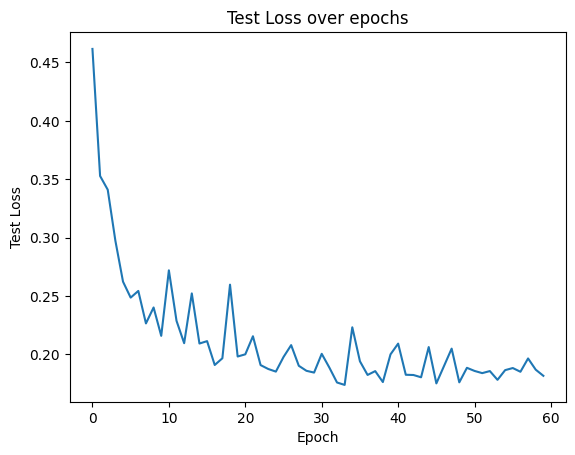

In [25]:
sns.lineplot(loss_ls)
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.title("Test Loss over epochs")
plt.show();

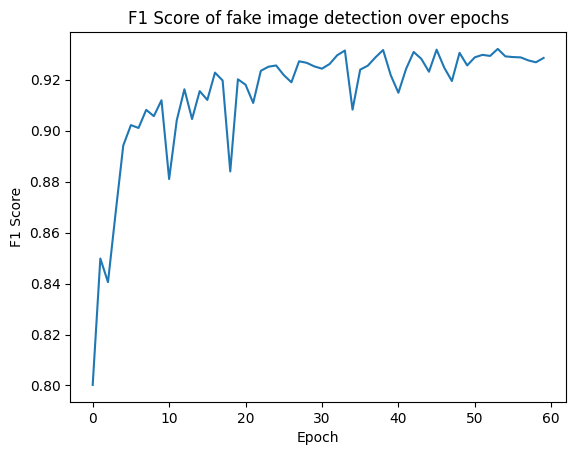

In [26]:
#test accuracy
sns.lineplot(f1_ls)
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score of fake image detection over epochs")
plt.show();

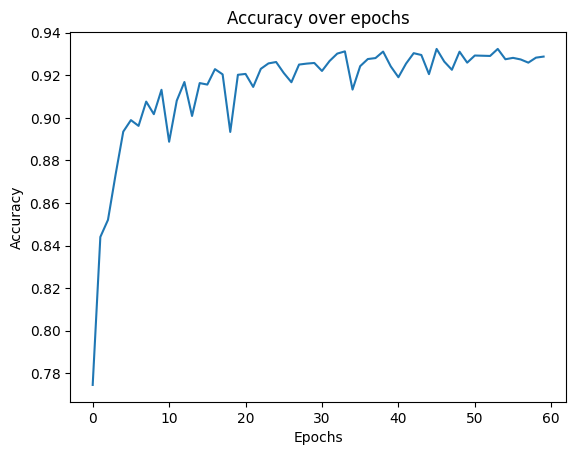

In [27]:
sns.lineplot(accuracy_score_ls)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs")
plt.show();

In [28]:
# #save the model
torch.save(model.state_dict(), "model.pth")

In [29]:
def display_cam(index, target_layer):
	image_tensor = test_data[index]
	real_class=image_tensor[1]
	image=image_tensor[0].permute(1, 2, 0)
	image_tensor = image_tensor[0].unsqueeze(0)

	#load the model
	model = CNN()
	model.load_state_dict(torch.load("model.pth"))
	#load the model to the same device as before
	model = model.to(device)
	model.eval()

	#get the cam extractor
	cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)

	output = model(image_tensor.to(device))

	with SmoothGradCAMpp(model, target_layer=target_layer) as cam_extractor:
		output = model(image_tensor.to(device)) #move the image tensor to the same device as the model
		activation_map = cam_extractor(output.squeeze(0).argmax().item(), output)


	#print actual vs prediction
	predicted_class = output.argmax(dim=1).item()# # Set your CAM extractor
	print(f"Index: {index}\nActual class: {"Fake (0)" if real_class==0 else "Real (1)"}, Predicted class: {"Fake (0)" if predicted_class==0 else "Real (1)"}")

	#overlay the CAM on the image
	result = overlay_mask(to_pil_image(image_tensor[0]), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

	#plot
	#print n images in train_data starting from starting_index
	plt.subplot(1, 2, 1) #subplot with 1 row and 5 columns
	plt.title("Original Image")
	plt.imshow(image)
	plt.axis('off')
	plt.subplot(1, 2, 2)
	plt.title("CAM Overlay")
	plt.imshow(result)
	plt.axis('off')


In [30]:
# Get a random image by index, as an image tensor
index=random.randint(10000, 20000) #randomly select an index from the test data
# ls=[400, 422, 437, 461, 464, 541, 542, 543, 550, 555, 569, 580, 597, 616, 646, 667, 714, 723, 758, 770, 790, 792, 799]
#real img pred fake

Index: 19348
Actual class: Real (1), Predicted class: Real (1)


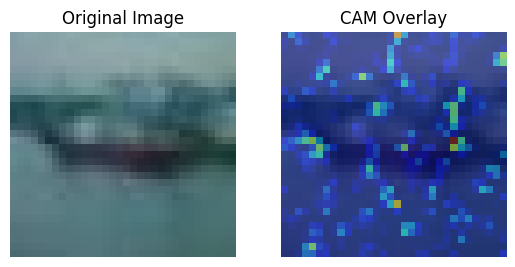

In [31]:
display_cam(index, target_layer="conv1") 

Index: 19348
Actual class: Real (1), Predicted class: Real (1)


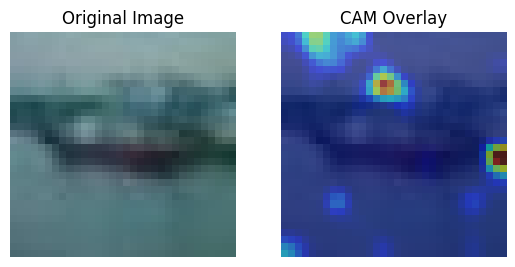

In [32]:
display_cam(index, target_layer="conv2")

[[9322  678]
 [ 746 9254]]


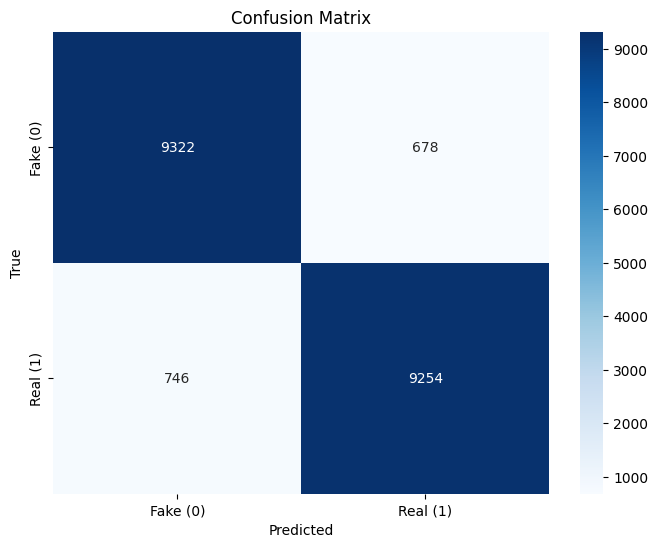

              precision    recall  f1-score   support

    Fake (0)       0.93      0.93      0.93     10000
    Real (1)       0.93      0.93      0.93     10000

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000



In [33]:
model.eval()

# Get the predictions for the test set
y_true = []
y_pred = []
for features, target in test_loader:
	features, target = features.to(device), target.to(device)
	output = model(features)
	label_out = torch.argmax(output, dim=1) #argmax returns the index of the maximum value in the tensor
	y_true.extend(target.cpu().numpy())
	y_pred.extend(label_out.cpu().numpy())


# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake (0)", "Real (1)"], yticklabels=["Fake (0)", "Real (1)"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Get the classification report
report = classification_report(y_true, y_pred, target_names=["Fake (0)", "Real (1)"])
print(report)

In [34]:
#get index of everything that's real but predicted fake

ls=[]

for i in range(len(y_pred)):
	if y_pred[i]==0 and y_true[i]==1:
		ls.append(i)

print(ls)

[10012, 10026, 10047, 10068, 10089, 10109, 10110, 10127, 10129, 10130, 10139, 10190, 10198, 10199, 10228, 10229, 10236, 10240, 10241, 10269, 10276, 10288, 10309, 10310, 10318, 10335, 10349, 10425, 10461, 10479, 10486, 10503, 10509, 10528, 10531, 10532, 10539, 10563, 10587, 10588, 10597, 10609, 10611, 10626, 10632, 10639, 10648, 10651, 10671, 10689, 10690, 10708, 10709, 10714, 10755, 10779, 10800, 10817, 10819, 10828, 10845, 10879, 10906, 10939, 10967, 10999, 11007, 11017, 11025, 11029, 11042, 11044, 11074, 11083, 11087, 11089, 11101, 11119, 11126, 11136, 11143, 11152, 11161, 11164, 11167, 11212, 11225, 11250, 11251, 11288, 11311, 11350, 11359, 11368, 11373, 11378, 11389, 11392, 11402, 11408, 11444, 11458, 11470, 11473, 11481, 11492, 11500, 11509, 11529, 11534, 11538, 11559, 11563, 11565, 11578, 11601, 11605, 11608, 11618, 11623, 11641, 11643, 11651, 11668, 11688, 11749, 11752, 11761, 11768, 11780, 11798, 11809, 11825, 11841, 11857, 11859, 11868, 11870, 11871, 11908, 11922, 11939, 11967

In [35]:
#save model
torch.save(model.state_dict(), "saved_models/CNN_from_scratch/model_full_train_test.pth")

RuntimeError: Parent directory saved_models/CNN_from_scratch does not exist.